# 1) Look up the “Rectified Adam” paper, implement it using the general optimizer framework, and try it out.

Data preparation for image classification:

In [1]:
from fastai.vision.all import *

In [2]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

In [3]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

In [4]:
def get_learner(**kwargs):
    return vision_learner(dls, resnet34, pretrained=False,
                    metrics=accuracy, **kwargs).to_fp16()

Fastai deafult (Adam):

In [ ]:
learn = get_learner()
learn.fit_one_cycle(3, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.443431,2.249912,0.338599,00:32
1,1.825139,2.010026,0.489682,00:31
2,1.511744,1.252514,0.588280,00:31


Rectified Adam:

In [5]:
def step_counter(p, step=0, **kwargs):
    step += 1
    return {'step': step}

In [68]:
def Rect_Adam(p, lr, step, beta1, beta2, pinf, eps, m=None, v=None, **kwargs):
    if m is None:
        m = torch.zeros_like(p.data)

    if v is None:
        v = torch.zeros_like(p.data)

    g = p.grad.data

    # Exponential moving average of the first moment
    m.mul_(beta1).add_(g, alpha=1 - beta1)
    m_unbias = m / (1 - beta1 ** step)

    # Exponential moving average of the second moment
    v.mul_(beta2).addcmul_(g, g, value=1 - beta2)

    # Length of approximated smoothened moving average
    pt = pinf - (2 * step * beta2 ** step) / (1 - beta2 ** step)

    if pt > 4:
        # Adaptive learning rate
        l = ((1 - beta2 ** step) / (v + eps)) ** 0.5
        # Variance rectification term
        r = (((pt-4) * (pt - 2) * pinf) / ((pinf - 4) * (pinf - 2) * pt)) ** 0.5
        # Update parameters with adaptive momentum
        p.data.addcmul_(m_unbias, l, value=-lr * r)
    else:
        # Update parameters without adaptive momentum
        p.data.addcdiv_(m_unbias, (v.sqrt() + eps), value=-lr)

    return {'m': m, 'v': v}

In [ ]:
opt_func = partial(Optimizer, cbs=[step_counter, Rect_Adam], beta1=0.9, beta2=0.99, pinf = 2/(1 - 0.99) - 1, eps=1e-5)

In [ ]:
learn = get_learner(opt_func=opt_func)
learn.fit(3, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.667588,1.954469,0.317707,00:47
1,2.159467,1.837099,0.344968,00:32
2,1.970665,5.623854,0.312102,00:32


fit_one_cycle works better with RAdam for this task

In [ ]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.598414,2.050672,0.367134,00:31
1,2.051831,1.465691,0.511847,00:35
2,1.645982,1.266870,0.617580,00:32


Fastai implementation of Rectified Adam:

In [ ]:
learn = get_learner(opt_func=RAdam)
learn.fit_one_cycle(3, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.772465,2.423433,0.306752,00:30
1,2.013493,1.637511,0.461911,00:30
2,1.612933,1.318004,0.565096,00:31


Adam-mini:

In [10]:
def setup(p, m=None, v=None, **kwargs):
    if m == None and v == None:
        m = torch.zeros_like(p.grad.data)
        # v is a single number for each parameter block
        v = 0.0

        return {'m': m, 'v': v}

In [11]:
def Adam_mini(p, lr, step, beta1, beta2, eps, m, v, **kwargs):
    g = p.grad.data

    # Exponential moving average of the first order
    m.mul_(beta1).add_(g, alpha = 1 - beta1)
    m_unbias = m / (1 - beta1 ** step)

    # Exponential moving average of the second order / the same for all parameters in a block
    v = beta2 * v + (1 - beta2) * torch.mean(g ** 2).item()
    v_unbias = v / (1 - beta2 ** step)

    # Update parameters
    p.data.add_(m_unbias, alpha=-lr / (v_unbias ** 0.5 + eps))

    return {'m': m, 'v': v}

In [12]:
opt_func = partial(Optimizer, cbs=[step_counter, setup, Adam_mini], beta1=0.9, beta2=0.99, eps=1e-5)

In [13]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.402538,2.061545,0.383439,00:41
1,1.846294,1.756478,0.471847,00:31
2,1.507708,1.268688,0.577325,00:29


Implementing this in fastai feels weird as hell, because fastai is splitting parameters into groups by deafult, and it initialises states for them separately.

# 2) Implement your own version of the learning rate finder from scratch. Compare it with fastai’s version.

In [14]:
class ExpSched():
    # Exponential schedule
    def __init__(self, start, end):
        self.start, self.end = start, end

    def __call__(self, pos):
        return self.start * (self.end / self.start) ** pos

In [15]:
class LrFinder(Callback):
    # high order means that LrFinder has low priority -> it needs to be the last one to update the learning rate,
    # also it has to be executed after smooth_loss has been calculated by Recorder callback
    order = 100

    def __init__(self, start=1e-7, end=10, steps=100):
        self.steps = steps
        self.lr = ExpSched(start, end)
        self.best_loss = float('inf')
        self.lrs = []
        self.losses = []

    # get rid of table with training stats
    def after_create(self):
        self.learn.create_mbar = False
        self.learn.logger = False

    # set learning rate of each hypers group to appropriate value and store that value for plotting the graph
    def before_batch(self):
        for i in range(len(self.opt.hypers)):
            self.learn.opt.hypers[i]['lr'] = self.lr(self.train_iter / self.steps)

        self.lrs.append(self.opt.hypers[0]['lr'])

    def after_batch(self):
        self.losses.append(self.smooth_loss)
        self.best_loss = min(self.best_loss, self.smooth_loss)
        if self.train_iter >= self.steps:
            raise CancelFitException()

        if self.smooth_loss > 4 * self.best_loss:
            raise CancelFitException()

    def before_validate(self):
        raise CancelValidException()

    # plot the graph, not including the last 5 points makes the graph look cleaner and much more readable, thats also what fastai .lr_find() does
    def after_fit(self):
        self.learn.opt.zero_grad()
        plt.figure()
        plt.plot(self.lrs[:-5], self.losses[:-5])
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Finder')
        plt.show()

In [16]:
n_iters = 100

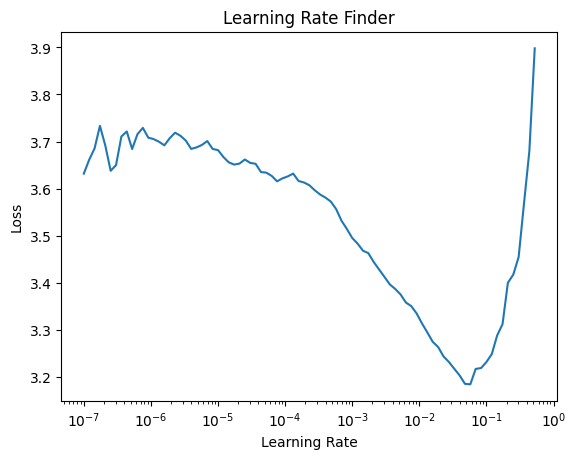

In [17]:
learn = get_learner(cbs=[LrFinder(steps=n_iters)])
# this equation makes sure that the number of epochs is just enough for the number of iterations
learn.fit(n_iters // len(learn.dls.train) + 1)

SuggestedLRs(valley=0.0012022644514217973)

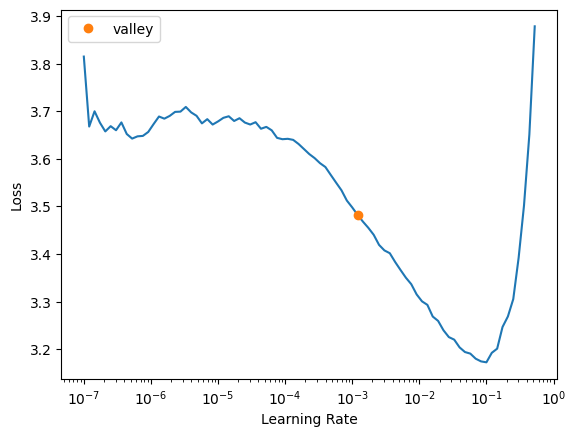

In [18]:
learn = get_learner()
learn.lr_find()

My implementation works the same as fastai's (but it doesn't include suggestion functions as I think they are not very helpful)